## DEMO IPYNB FOR FINAL SUBMMISION EVALUTATION ##
Dataset loading
  
Please load the appropreate dataset and pth first before execution

In [28]:
import os
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/data_full_9067.zip" -d /content/dataset



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/dataset/data_full/canvas_sporty_lace_up_footwear_sneaker_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:

ckpt_dir  = "/content/dataset/"                  # change if your file lives elsewhere
ckpt_name = "pooled_9067_full_checkpoint.pth"
ckpt_path = os.path.join(ckpt_dir, ckpt_name)


In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6jtn8snc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6jtn8snc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig
import os
import matplotlib.pyplot as plt
import math


from scipy import linalg
from torchvision.models import inception_v3
import clip


In [5]:
# assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"currently running on {device}")

currently running on cuda


# BERT Class

In [6]:
# Dataset Class
class FashionCaptionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2. - 1.) # map to [-1,1] for centered training
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Extract caption from filename
        caption = self.image_files[idx].replace('.png', '')
        caption = caption.replace('_', ' ').replace('.', ' ')
        caption = ' '.join(caption.split())  # Clean extra spaces

        return self.transform(image), caption

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.proj = nn.Linear(768, 256)  # Project to smaller dimension
        self.gelu = nn.GELU()

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, captions):
        inputs = self.tokenizer(
            captions,
            padding=True,
            truncation=True,
            max_length=32,
            return_tensors="pt"
        ).to(device)

        outputs = self.bert(**inputs)
        # pooled = outputs.last_hidden_state
        token_embeddings = outputs.last_hidden_state  # (B, T, 768)
        attention_mask = inputs['attention_mask'].unsqueeze(-1).expand(token_embeddings.size())  # (B, T, 768)

        # Zero out the padding tokens
        masked_embeddings = token_embeddings * attention_mask
        summed = masked_embeddings.sum(dim=1)  # (B, 1)
        counts = attention_mask.sum(dim=1)     # (B, 1)

        mean_pooled = summed / counts.clamp(min=1e-9)  # avoid divide-by-zero


        return self.gelu(self.proj(mean_pooled))

In [7]:
ds = FashionCaptionDataset('/content/dataset/data_full')
print(len(ds))
test_size = int(0.2 * len(ds))
train_size = len(ds) - test_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

9067


(5, 256)


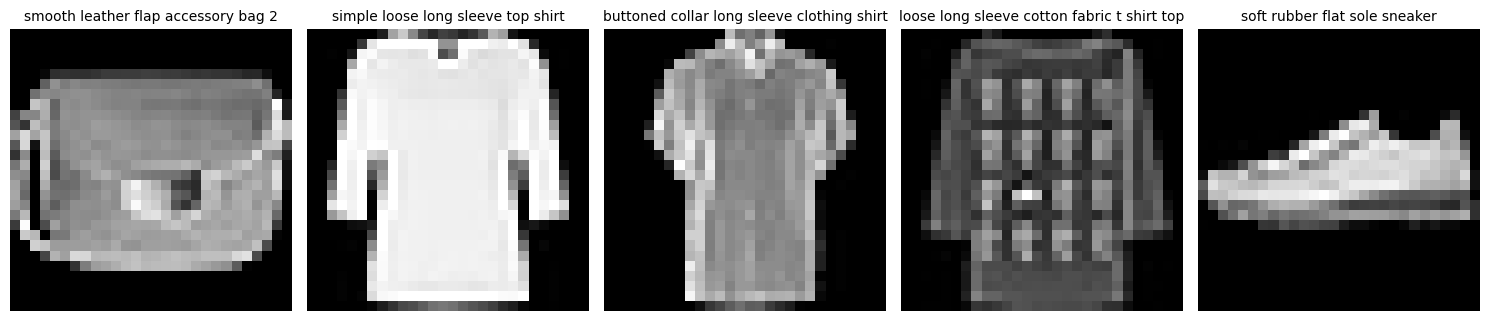


Caption 1: smooth leather flap accessory bag 2
Embedding shape: (256,)

Caption 2: simple loose long sleeve top shirt
Embedding shape: (256,)

Caption 3: buttoned collar long sleeve clothing shirt
Embedding shape: (256,)

Caption 4: loose long sleeve cotton fabric t shirt top
Embedding shape: (256,)

Caption 5: soft rubber flat sole sneaker
Embedding shape: (256,)


In [21]:
# Get one batch
x_batch, y_batch = next(iter(train_loader))  # x: [B, 1, 28, 28], y: list of captions
x_batch = x_batch[:5]  # select first 5 samples
y_batch = y_batch[:5]  # corresponding captions

# Send to device and encode
x_batch = x_batch.to(device)
text_encoder = TextEncoder().to(device)


with torch.no_grad():
    text_embeddings = text_encoder(y_batch).cpu().numpy()  # shape: [5, N, 128]
    print(text_embeddings.shape)
# Plot images and print embeddings
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow((x_batch[i].cpu().squeeze() + 1) / 2, cmap='gray')  # inverse normalize
    axs[i].axis('off')
    axs[i].set_title(f"{y_batch[i]}", fontsize=10)

plt.tight_layout()
plt.show()

# Show text embedding summaries
for i in range(5):
    print(f"\nCaption {i+1}: {y_batch[i]}")
    print(f"Embedding shape: {text_embeddings[i].shape}")

# Converting images from pixels to Patches

In [9]:
def convert_image_to_patches(image, patch_size = 4):
  B, ch, weight, height = image.shape

  patch = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
  print(patch.shape)
  patch = patch.permute(0, 2, 3, 1, 4, 5) # [B, patch_height, patch_width, ch, patch_size, patch_size]
  print(patch.shape)
  patch = patch.contiguous().view(B, -1, ch * patch_size * patch_size) # [B, patch_number, patch_size ** 2]
  return patch


print(x_batch.shape)
image_patch = convert_image_to_patches(x_batch, 4)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 7, 7, 4, 4])
torch.Size([5, 7, 7, 1, 4, 4])


# Cross Attention between text and image in embedding space

In [10]:
# Text to image cross attention between text to image
class CrossAttention(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(CrossAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim_q, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim_q)

  def forward(self, image_query, text_context):
    """
    image_query: used for the image [BS, N_query, dim_q]
    text_context: used for the text [BS, N_context, dim_k_v]
    for all N_query and N_context: N the number of tokens in the sequence
    for image: for a patch of 16 * 16 --> (256 / 16) * (256 / 16) = 256 --> basically to prevent image token to be too long
    """
    BS = image_query.shape[0]
    N_query = image_query.shape[1]
    N_context = text_context.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(image_query)
    q = q.view(BS, N_query, self.head, self.dim_head).transpose(1, 2)

    k = self.k(text_context)
    k = k.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    v = self.v(text_context)
    v = v.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N_query, -1)) #[B, N_image, patch_size ** 2]



In [11]:
# Self attention on the images
# the dim variable correspond to image dim
class SelfAttention(nn.Module):
  def __init__(self, dim, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(SelfAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim)

  def forward(self, x):
    BS = x.shape[0]
    N = x.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(x)
    q = q.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    k = self.k(x)
    k = k.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    v = self.v(x)
    v = v.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N, -1)) #[B, N_image, patch_size ** 2]



# Attention_block

https://arxiv.org/pdf/2112.10752

In [12]:
class CrossAttentionBlock(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, linear_scale=2, dropout=0.5, bias_setting=False):
    super(CrossAttentionBlock, self).__init__()
    self.dim_q = dim_q
    self.dim_k_v = dim_k_v
    self.head = head
    self.dim_head = dim_head

    # layer norms
    self.layer_norm_attn = nn.LayerNorm(dim_q)
    self.layer_norm_mlp = nn.LayerNorm(dim_q)
    self.layer_norm_self_attn = nn.LayerNorm(dim_q)


    # MLP
    self.mlp = nn.Sequential(
        nn.Linear(dim_q, dim_q * linear_scale),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim_q * linear_scale, dim_q)
    )

    # cross attention
    self.cross_attn = CrossAttention(dim_q, dim_k_v, head, dim_head, bias_setting)
    self.self_attn = SelfAttention(dim_q, head, dim_head, bias_setting)

  def forward(self, image, text, timestamp):
    # code begins below
    image = image + timestamp
    # image = self.layer_norm_self_attn(image)
    # image = image + self.self_attn(image)
    image = self.layer_norm_attn(image)
    image = image + self.cross_attn(image, text)
    image = self.layer_norm_mlp(image)
    image = image + self.mlp(image)

    return image



In [13]:
# Self attention on the images
# the dim variable correspond to image dim
class SelfAttention(nn.Module):
  def __init__(self, dim, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(SelfAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim)

  def forward(self, x):
    BS = x.shape[0]
    N = x.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(x)
    q = q.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    k = self.k(x)
    k = k.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    v = self.v(x)
    v = v.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N, -1)) #[B, N_image, patch_size ** 2]



# Hyperparameters

In [14]:

cnn_params = {
    'kernel_size_1':         3,
    'stride_1':              2,
    'padding_1':             1,
    'kernel_size_2':         3,
    'stride_2':              2,
    'padding_2':             1,
    'inter_layer_channel':   64,
    'inter_layer_channel_2': 128,
    'encoder_T':             4,
    'encoder_head':          2,
    'encoder_head_dim':      32,
}

trans_cnn_params = {
    'kernel_size_trans_1':      3,
    'stride_trans_1':           2,
    'padding_trans_1':          1,
    'output_padding_trans_1':   1,
    'kernel_size_trans_2':      3,
    'stride_trans_2':           2,
    'padding_trans_2':          1,
    'output_padding_trans_2':   1,
    'inter_layer_channel_1':    64,
    'decoder_T':                4,
    'decoder_head':             2,
    'decoder_head_dim':         32,
}


attn_params = {
    'dim_q':           cnn_params['inter_layer_channel_2'],
    'dim_k_v':         256,
    'dim_timestamp':   128,
    'head':            2,
    'dim_head':        128,
    'T':               4,
}

# Unet V2

In [15]:
class UNet(nn.Module):
  def __init__(self, channel, time_dim, cnn_params, trans_cnn_params, attn_params, bias_settings=False, linear_scale=2, dropout=0.5):
    super(UNet, self).__init__()
    self.channel = channel
    self.bias_settings = bias_settings
    self.linear_scale = linear_scale
    self.dropout = dropout
    self.time_dim = time_dim

    self.relu = nn.ReLU()

    self.attn_dim_k_v = attn_params['dim_k_v']

    # ----- Encoder Convs -----
    self.encoder_T = cnn_params["encoder_T"]
    self.encoder_head = cnn_params["encoder_head"]
    self.encoder_head_dim = cnn_params["encoder_head_dim"]
    self.encoder_bn_layer_norm = nn.LayerNorm(cnn_params['inter_layer_channel'])

    self.conv1 = nn.Conv2d(channel,
                           cnn_params['inter_layer_channel'],
                           cnn_params['kernel_size_1'],
                           cnn_params['stride_1'],
                           cnn_params['padding_1'],
                           bias=bias_settings)

    self.conv2 = nn.Conv2d(cnn_params['inter_layer_channel'],
                           cnn_params['inter_layer_channel_2'],
                           cnn_params['kernel_size_2'],
                           cnn_params['stride_2'],
                           cnn_params['padding_2'],
                           bias=bias_settings)

    self.conv1x1_flatten = nn.Conv2d(cnn_params['inter_layer_channel'],
                                     self.encoder_head * self.encoder_head_dim,
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.conv1x1_unflatten = nn.Conv2d(self.encoder_head * self.encoder_head_dim,
                                     cnn_params['inter_layer_channel'],
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.encoder_attn_block = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.encoder_head * self.encoder_head_dim,
            dim_k_v=self.attn_dim_k_v,
            head=self.encoder_head,
            dim_head=self.encoder_head_dim
        )
        for _ in range(self.encoder_T)
    ])

    # ----- Decoder Transpose Convs -----
    # these are conv2d blocks, but just following the naming convention
    self.decoder_T = trans_cnn_params["decoder_T"]
    self.decoder_head = trans_cnn_params["decoder_head"]
    self.decoder_head_dim = trans_cnn_params["decoder_head_dim"]
    self.decoder_bn_layer_norm = nn.LayerNorm(trans_cnn_params['inter_layer_channel_1'])

    self.deconv1 = nn.ConvTranspose2d(cnn_params['inter_layer_channel_2'],
                                      trans_cnn_params['inter_layer_channel_1'],
                                      trans_cnn_params['kernel_size_trans_1'],
                                      trans_cnn_params['stride_trans_1'],
                                      trans_cnn_params['padding_trans_1'],
                                      trans_cnn_params['output_padding_trans_1'],
                                      bias=bias_settings)

    self.deconv2 = nn.ConvTranspose2d(trans_cnn_params['inter_layer_channel_1'],
                                      channel,
                                      trans_cnn_params['kernel_size_trans_2'],
                                      trans_cnn_params['stride_trans_2'],
                                      trans_cnn_params['padding_trans_2'],
                                      trans_cnn_params['output_padding_trans_2'],
                                      bias=bias_settings)

    self.deconv1x1_flatten = nn.Conv2d(trans_cnn_params['inter_layer_channel_1'],
                                     self.decoder_head * self.decoder_head_dim,
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.deconv1x1_unflatten = nn.Conv2d(self.encoder_head * self.encoder_head_dim,
                                     trans_cnn_params['inter_layer_channel_1'],
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.decoder_attn_block = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.decoder_head * self.decoder_head_dim,
            dim_k_v=self.attn_dim_k_v,
            head=self.decoder_head,
            dim_head=self.decoder_head_dim
        )
        for _ in range(self.decoder_T)
    ])



    # -------- attn (bottleneck) --------
    self.bn_layer_norm = nn.LayerNorm(cnn_params['inter_layer_channel_2'])

    self.attn_dim_q = attn_params['dim_q']
    self.attn_dim_timestamp = attn_params['dim_timestamp']
    self.attn_head = attn_params['head']
    self.attn_dim_head = attn_params['dim_head']
    self.T = attn_params['T'] # this is the number of stacked attention blocks

    # attention blocks according to T
    self.attn_blocks = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.attn_dim_head * self.attn_head,
            dim_k_v=self.attn_dim_k_v,
            head=self.attn_head,
            dim_head=self.attn_dim_head
        )
        for _ in range(self.T)
    ])


    # ------- time projections -------

    self.time_proj = nn.Sequential(
        nn.Linear(self.time_dim, self.channel),
        nn.SiLU(),
    )

    self.time_proj_2 = nn.Sequential(
        nn.Linear(cnn_params["inter_layer_channel_2"], linear_scale * cnn_params["inter_layer_channel_2"]),
        nn.SiLU(),
        nn.Linear(linear_scale * cnn_params["inter_layer_channel_2"], self.attn_dim_head * self.attn_head)
    )

    self.encoder_time_proj = nn.Sequential(
        nn.Linear(cnn_params["inter_layer_channel"], linear_scale * cnn_params["inter_layer_channel"]),
        nn.SiLU(),
        nn.Linear(linear_scale * cnn_params["inter_layer_channel"], self.encoder_head_dim * self.encoder_head)
    )

    self.decoder_time_proj = nn.Sequential(
        nn.Linear(trans_cnn_params["inter_layer_channel_1"], linear_scale * trans_cnn_params["inter_layer_channel_1"]),
        nn.SiLU(),
        nn.Linear(linear_scale * trans_cnn_params["inter_layer_channel_1"], self.decoder_head_dim * self.decoder_head)
    )

    # -------- 1x1 conv ---------
    self.to_bottleneck_conv = nn.Conv2d(cnn_params["inter_layer_channel_2"], self.attn_head * self.attn_dim_head, kernel_size=1, bias=self.bias_settings)
    self.leave_bottleneck_conv = nn.Conv2d(self.attn_head * self.attn_dim_head, cnn_params["inter_layer_channel_2"], kernel_size=1, bias=self.bias_settings)

  def sinusoidal_positional_embedding(self, t, dim):
    denominator = torch.pow(10000, torch.arange(0, dim, 2).float().to(t.device) / dim)
    val = t.float().unsqueeze(-1) / denominator  # (B, dim/2)
    positional_embedding = torch.cat([torch.sin(val), torch.cos(val)], dim=-1)  # (B, dim)
    return positional_embedding # [B, dim]


  def encoder(self, image, text, timestamp):
    # skip connections for Unet architecture
    skip_connections = []

    image = self.conv1(image)
    image = self.relu(image)


    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.encoder_bn_layer_norm(image)
    image = image.view(B, C, H, W)

    skip_connections.append(image)

    # atteniton blocks at encoder level
    image = self.conv1x1_flatten(image)

    image = image.view(B, H*W, self.encoder_head * self.encoder_head_dim) # [B, N_image, image_embedding]
    encoder_attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, cnn_params["inter_layer_channel"])
    encoder_attn_time_embedding = self.encoder_time_proj(encoder_attn_time_embedding)
    encoder_attn_time_embedding = encoder_attn_time_embedding.unsqueeze(1)
    text = text.unsqueeze(1)

    for block in self.encoder_attn_block:
      image = block(image, text, encoder_attn_time_embedding)

    image = image.view(B, self.encoder_head * self.encoder_head_dim, H, W)

    image = self.conv1x1_unflatten(image)
    image = image.view(B, C, H, W)

    # second layer of CNN
    image = self.conv2(image)
    image = self.relu(image)
    skip_connections.append(image)
    return image, skip_connections

  def decoder(self, image, text, timestamp, skip_connections):
    image = self.deconv1(image + skip_connections[1])
    image = self.relu(image)

    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.decoder_bn_layer_norm(image)
    image = image.view(B, C, H, W)

    skip_connections.append(image)

    # atteniton blocks at encoder level
    image = self.deconv1x1_flatten(image)

    image = image.view(B, H*W, self.decoder_head * self.decoder_head_dim) # [B, N_image, image_embedding]
    decoder_attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, trans_cnn_params["inter_layer_channel_1"])
    decoder_attn_time_embedding = self.encoder_time_proj(decoder_attn_time_embedding)
    decoder_attn_time_embedding = decoder_attn_time_embedding.unsqueeze(1)
    text = text.unsqueeze(1)
    for block in self.decoder_attn_block:
      image = block(image, text, decoder_attn_time_embedding)

    image = image.view(B, self.decoder_head * self.decoder_head_dim, H, W)

    image = self.deconv1x1_unflatten(image)
    image = image.view(B, C, H, W)

    image = self.deconv2(image + skip_connections[0])
    return image


  def forward(self, image, text, timestamp):
    # handle timestamp positional embedding
    time_embedding = self.sinusoidal_positional_embedding(timestamp, self.time_dim)
    time_embedding = self.time_proj(time_embedding)

    B, C = time_embedding.shape
    time_embedding = time_embedding.view(B, C, 1, 1).expand(-1, -1, image.shape[2], image.shape[3])
    image = image + time_embedding

    # handle encoding path of the Unet
    image, skip_connections = self.encoder(image, text, timestamp)
    # handle bottleneck cross attention
    """
    Here is quite complicated and it is strongly recommended to read stable diffusion's paper
    https://arxiv.org/pdf/2112.10752.pdf at page 26
    For our model, we made a lot, i meant a lot of simplifications due to limited resources

    In the original architecture, attention (cross attention is applied in encoder and decoder as well)
    For simplicity, we are putting cross attention in the bottleneck, also we ignored the conv layers in the bottleneck as well
    """
    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.bn_layer_norm(image)
    image = image.view(B, C, H, W)

    # conv2d 1x1
    image = self.to_bottleneck_conv(image)

    image = image.view(B, H*W, self.attn_head * self.attn_dim_head) # [B, N_image, image_embedding]

    attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, self.attn_dim_timestamp)
    attn_time_embedding = self.time_proj_2(attn_time_embedding)
    attn_time_embedding = attn_time_embedding.unsqueeze(1)
    text = text.unsqueeze(1)
    for block in self.attn_blocks:
      image = block(image, text, attn_time_embedding)

    image = image.view(B, self.attn_head * self.attn_dim_head, H, W)

    # conv2d 1x1
    image = self.leave_bottleneck_conv(image)
    image = image.view(B, C, H, W)

    # handle decoding path of the Unet
    image = self.decoder(image, text, timestamp, skip_connections)

    return image


# Model Initialization

In [16]:


model = UNet(
    channel=1,
    time_dim=128,
    cnn_params=cnn_params,
    trans_cnn_params=trans_cnn_params,
    attn_params=attn_params,
    bias_settings=False
).to(device)


# DDPM Variables

For the demoing purposes, you may just simply load the pth and run the sampling without training to evaluate results.

In [17]:
T = 1000 # total diffusion steps

def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x     = torch.linspace(0, T, steps, dtype=torch.float64, device=device)
    alphas_cumprod = torch.cos(((x/T + s)/(1 + s)) * math.pi/2)**2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(min=1e-8, max=0.999).float()

beta      = cosine_beta_schedule(T)
alpha     = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Prepare a single “empty” embedding for unconditional runs
empty_tokens       = [""]                # an empty string as “null” prompt
empty_embed_single = text_encoder(empty_tokens).to(device)  # [1, N_text, D_text]

# model instantiate above
#text_encoder = TextEncoder().to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3)

epochs = 250
train_loss_list = []
drop_prob = 0.1


Our entire Training Process has been skipped. Proceed directly into loading

In [23]:
checkpoint = torch.load(ckpt_path, map_location=device)

model.load_state_dict(checkpoint["unet_state_dict"])
text_encoder.load_state_dict(checkpoint["text_encoder_state_dict"])

start_epoch = checkpoint["epoch"] + 1

model.eval()
text_encoder.eval()

TextEncoder(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [24]:
@torch.no_grad()
def sample_with_cfg_dynamic_threshold(
    description,
    model,
    text_encoder,
    seed=42,
    img_size=28,
    guidance_scale=2.0,
    p_clip=0.995
):
    model.eval()
    text_encoder.eval()


    cond_embed   = text_encoder([description]).to(device)   # [1, N, D]
    uncond_embed = empty_embed_single                       # [1, N, D]


    gen = torch.Generator(device=device).manual_seed(seed)
    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5
    T_steps = beta.shape[0]

    for t in reversed(range(1, T_steps)):
        t_batch = torch.tensor([t], device=device)


        a_t  = torch.clamp(alpha[t],     min=eps)
        ab_t = torch.clamp(alpha_bar[t], min=eps)


        eps_uncond = model(x, uncond_embed, t_batch)
        eps_cond   = model(x, cond_embed,   t_batch)
        eps_pred   = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        sqrt_ab_t   = torch.sqrt(ab_t)
        sqrt_1_ab_t = torch.sqrt(1 - ab_t)
        x0_pred = (x - sqrt_1_ab_t * eps_pred) / sqrt_ab_t


        flat = x0_pred.view(-1).abs()
        s = torch.quantile(flat, p_clip).item()
        s = max(s, 1.0)  # ensure >=1 to avoid amplifying
        x0_pred = x0_pred.clamp(-s, s) / s


        eps_pred = (x - sqrt_ab_t * x0_pred) / sqrt_1_ab_t


        coef1 = 1.0 / torch.sqrt(a_t)
        coef2 = beta[t] / torch.sqrt(1 - ab_t)
        mean  = coef1 * (x - coef2 * eps_pred)

        ab_prev    = alpha_bar[t-1] if t > 1 else torch.tensor(1.0, device=device)
        tilde_beta = beta[t] * (1 - ab_prev) / (1 - ab_t)
        sigma_t    = torch.sqrt(tilde_beta)


        noise = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
        x = mean + sigma_t * noise

    return x

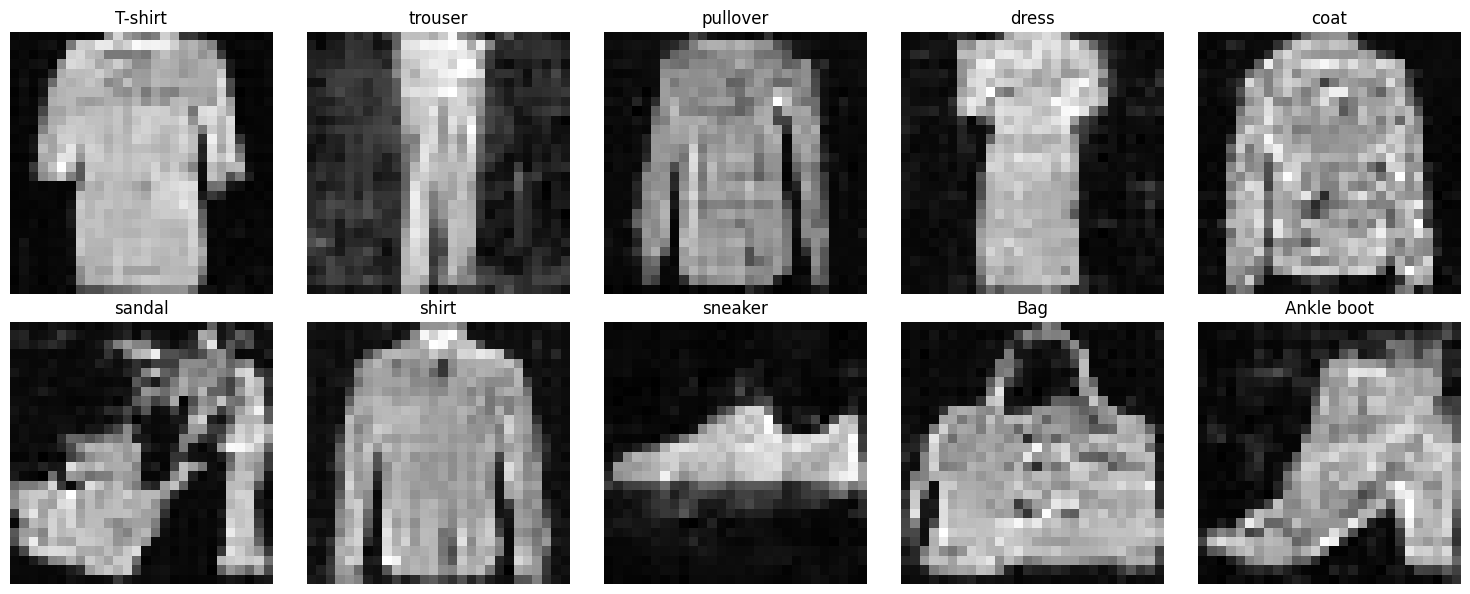

In [27]:
import matplotlib.pyplot as plt

# # Generate one sample per Fashion-MNIST class with simple prompts
img1  = sample_with_cfg_dynamic_threshold("cozy plain short sleeve T-shirt", model, text_encoder)  # class 0
img2  = sample_with_cfg_dynamic_threshold("long slim straight fabric trouser",      model, text_encoder)  # class 1
img3  = sample_with_cfg_dynamic_threshold("cozy long sleeve cotton top pullover",           model, text_encoder)  # class 2
img4  = sample_with_cfg_dynamic_threshold("fitted short sleeve long dress ",        model, text_encoder)  # class 3
img5  = sample_with_cfg_dynamic_threshold("thick padded warm coat",          model, text_encoder)  # class 4
img6  = sample_with_cfg_dynamic_threshold("open strap high heeled sandal",            model, text_encoder)  # class 5
img7  = sample_with_cfg_dynamic_threshold("formal button-down professional shirt",          model, text_encoder)  # class 6
img8  = sample_with_cfg_dynamic_threshold("canvas lace flat sneaker",     model, text_encoder)  # class 7
img9  = sample_with_cfg_dynamic_threshold("large leather carry handle bag",             model, text_encoder)  # class 8
img10 = sample_with_cfg_dynamic_threshold("dark high heel leather boot",        model, text_encoder)  # class 9

# Collect images and titles
images = [img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]
titles = [
    "T-shirt", "trouser", "pullover", "dress", "coat", "sandal",
    "shirt", "sneaker",  "Bag",   "Ankle boot"
]

# Plot in a 2×5 grid
rows, cols = 2, 5
plt.figure(figsize=(15, 6))
for idx, (im, title) in enumerate(zip(images, titles)):
    ax = plt.subplot(rows, cols, idx + 1)
    img = (im.squeeze().cpu().clamp(-1, 1) + 1) / 2
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Live generation


In [ ]:
def live_gen():
  desc = input("Describe an fashion clothing: ")
  img = sample_with_cfg_dynamic_threshold(desc, model, text_encoder, T)
  plt.figure(figsize=(12, 3))
  plt.imshow((img.squeeze().cpu().clamp(-1, 1) + 1) / 2, cmap='gray')
  plt.title(desc)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

live_gen()

# Evaluation Proccess

In [ ]:
class InceptionFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        net = inception_v3(pretrained=True, transform_input=False)
        net.fc = torch.nn.Identity()          # nix the classifier
        self.net = net.eval().to(device)

    @torch.no_grad()
    def forward(self, x):                     # x in [0,1], shape B×3×H×W
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        return self.net(x)                    # (B, 2048)


def to_inception_range(img):
    """img:  B×1×28×28  or  B×3×28×28  in [-1,1]"""
    img = (img + 1) / 2          # → [0,1]
    if img.shape[1] == 1:        # grayscale → RGB
        img = img.repeat(1, 3, 1, 1)
    return img


@torch.no_grad()
def extract_feats(loader, feat_net, gen_model=None, text_encoder=None):
    """
    If gen_model is None  →  REAL images path
    else                  →  FAKE images generated w/ classifier‑free guidance
    """
    all_feats = []
    for imgs, caps in tqdm(loader, desc="feat"):
        if gen_model is not None:
            # build a fake batch one caption at a time
            fake_batch = []
            for c in caps:
                fake = sample_with_cfg(
                    c,
                    gen_model, text_encoder)

                fake_batch.append(fake)
            imgs = torch.cat(fake_batch, dim=0)

        imgs = to_inception_range(imgs.to(device))
        feats = feat_net(imgs).cpu().numpy()
        all_feats.append(feats)

    return np.concatenate(all_feats, axis=0)


def frechet(mu1,  sg1,  mu2,  sg2, eps=1e-6):
    diff   = mu1 - mu2
    cov12, _ = linalg.sqrtm(sg1 @ sg2, disp=False)
    if not np.isfinite(cov12).all():
        eye = np.eye(sg1.shape[0]) * eps
        cov12 = linalg.sqrtm((sg1 + eye) @ (sg2 + eye))
    if np.iscomplexobj(cov12):
        cov12 = cov12.real
    return diff @ diff + np.trace(sg1 + sg2 - 2 * cov12)


def compute_fid(loader, gen_model, text_encoder):
    feat_net = InceptionFeatureExtractor()
    print("→ extracting REAL feats")
    real_f = extract_feats(loader, feat_net)
    print("→ extracting FAKE feats")
    fake_f = extract_feats(loader, feat_net,
                           gen_model=gen_model,
                           text_encoder=text_encoder)

    mu_r , sg_r = real_f.mean(0), np.cov(real_f,  rowvar=False)
    mu_f , sg_f = fake_f.mean(0), np.cov(fake_f,  rowvar=False)

    fid = frechet(mu_r, sg_r, mu_f, sg_f)
    print(f"FID = {fid:.2f}")
    return fid


In [ ]:
def evaluate_clip_and_fid(
    test_loader,
    model,
    text_encoder,
    sample_fn,
    save_dir        = "/content/eval_samples",
    max_samples     = None,
    clip_variant    = "ViT-B/32",
    device          = None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)


    clip_model, _ = clip.load(clip_variant, device=device)
    clip_model.eval()
    clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073],
                             device=device).view(1, 3, 1, 1)
    clip_std  = torch.tensor([0.26862954, 0.26130258, 0.27577711],
                             device=device).view(1, 3, 1, 1)

    def to_clip(x28):
        x = (x28 + 1) / 2
        x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, 224, mode="bilinear", align_corners=False)
        return (x - clip_mean) / clip_std


    feat_net = InceptionFeatureExtractor().to(device).eval()
    feats_real_all, feats_gen_all = [], []

    tot_clip_real, tot_clip_gen, n_seen = 0.0, 0.0, 0
    batch_ix = 0

    with torch.no_grad():
        for real_imgs28, captions in test_loader:
            if max_samples is not None and n_seen >= max_samples:
                break
            if max_samples is not None:
                remain = max_samples - n_seen
                if remain < real_imgs28.size(0):
                    real_imgs28 = real_imgs28[:remain]
                    captions    = captions[:remain]

            B          = real_imgs28.size(0)
            real_imgs28 = real_imgs28.to(device)


            gen_imgs28 = torch.cat(
                [sample_fn(cap, model, text_encoder).to(device)
                 for cap in captions], dim=0)


            for j, (img28, cap) in enumerate(zip(gen_imgs28, captions)):
                fn = f"{n_seen+j:06d}_{cap.replace(' ','_')[:60]}.png"
                img_uint8 = ((img28.cpu().numpy()[0] + 1) * 127.5)\
                             .clip(0, 255).astype(np.uint8)
                Image.fromarray(img_uint8).save(os.path.join(save_dir, fn))


            txt_tok   = clip.tokenize(captions).to(device)
            feat_r_cl = clip_model.encode_image(to_clip(real_imgs28))
            feat_g_cl = clip_model.encode_image(to_clip(gen_imgs28))
            feat_t_cl = clip_model.encode_text(txt_tok)

            for t in (feat_r_cl, feat_g_cl, feat_t_cl):
                t /= t.norm(dim=-1, keepdim=True)

            sim_r = (feat_r_cl * feat_t_cl).sum(-1)   # B
            sim_g = (feat_g_cl * feat_t_cl).sum(-1)   # B

            clip_real_batch = sim_r.mean().item()
            clip_gen_batch  = sim_g.mean().item()

            tot_clip_real += sim_r.sum().item()
            tot_clip_gen  += sim_g.sum().item()


            def fid_feat(x28):
                x = to_inception_range(x28)
                return feat_net(x).cpu().numpy()

            feat_r = fid_feat(real_imgs28)
            feat_g = fid_feat(gen_imgs28)

            feats_real_all.append(feat_r)
            feats_gen_all .append(feat_g)


            mu_r_b, mu_g_b = feat_r.mean(0), feat_g.mean(0)
            sg_r_b = np.cov(feat_r, rowvar=False)
            sg_g_b = np.cov(feat_g, rowvar=False)
            fid_batch = frechet(mu_r_b, sg_r_b, mu_g_b, sg_g_b)


            batch_ix += 1
            print(f"[B#{batch_ix:02d}]  • CLIP ⟨real      , prompt⟩ = "
                  f"{clip_real_batch:.4f}\n"
                  f"        • CLIP ⟨generated , prompt⟩ = "
                  f"{clip_gen_batch:.4f}\n"
                  f"        • FID(real ↔ generated)     = "
                  f"{fid_batch:.2f}")

            n_seen += B


    feats_real_all = np.concatenate(feats_real_all, 0)
    feats_gen_all  = np.concatenate(feats_gen_all,  0)

    mu_r, mu_g = feats_real_all.mean(0), feats_gen_all.mean(0)
    sg_r       = np.cov(feats_real_all, rowvar=False)
    sg_g       = np.cov(feats_gen_all,  rowvar=False)
    fid_global = frechet(mu_r, sg_r, mu_g, sg_g)

    avg_clip_real = tot_clip_real / n_seen
    avg_clip_gen  = tot_clip_gen  / n_seen

    return {
        "avg_clip_real": avg_clip_real,
        "avg_clip_gen" : avg_clip_gen,
        "fid"          : fid_global,
        "n_evaluated"  : n_seen,
        "save_dir"     : save_dir
    }

In [ ]:
metrics = evaluate_clip_and_fid(
    test_loader   = test_loader,
    model         = model,
    text_encoder  = text_encoder,
    sample_fn     = sample_with_cfg_dynamic_threshold,
    save_dir      = "/content/eval_samples",
    max_samples   = 1000      # or None for full set
)

print(f"Evaluated {metrics['n_evaluated']} pairs")
print(f"  • CLIP ⟨real       , prompt⟩ = {metrics['avg_clip_real']:.4f}")
print(f"  • CLIP ⟨generated  , prompt⟩ = {metrics['avg_clip_gen']:.4f}")
print(f"  • FID(real ↔ generated)      = {metrics['fid']:.4f}")
print(f"Generated images saved under → {metrics['save_dir']}")

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 45.8MiB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 222MB/s] 
/tmp/ipython-input-3960901460.py:67: DeprecationWarning: The `disp` argument is de

[B#01]  • CLIP ⟨real      , prompt⟩ = 0.2559
        • CLIP ⟨generated , prompt⟩ = 0.2389
        • FID(real ↔ generated)     = 187.54
[B#02]  • CLIP ⟨real      , prompt⟩ = 0.2651
        • CLIP ⟨generated , prompt⟩ = 0.2335
        • FID(real ↔ generated)     = 213.02
[B#03]  • CLIP ⟨real      , prompt⟩ = 0.2568
        • CLIP ⟨generated , prompt⟩ = 0.2344
        • FID(real ↔ generated)     = 209.54
[B#04]  • CLIP ⟨real      , prompt⟩ = 0.2593
        • CLIP ⟨generated , prompt⟩ = 0.2288
        • FID(real ↔ generated)     = 174.76
[B#05]  • CLIP ⟨real      , prompt⟩ = 0.2537
        • CLIP ⟨generated , prompt⟩ = 0.2363
        • FID(real ↔ generated)     = 197.63
[B#06]  • CLIP ⟨real      , prompt⟩ = 0.2559
        • CLIP ⟨generated , prompt⟩ = 0.2246
        • FID(real ↔ generated)     = 180.86
[B#07]  • CLIP ⟨real      , prompt⟩ = 0.2581
        • CLIP ⟨generated , prompt⟩ = 0.2374
        • FID(real ↔ generated)     = 185.39
[B#08]  • CLIP ⟨real      , prompt⟩ = 0.2517
        • 